<span>
<img src="img/cdlib_new.png" width="120px" align="right"/>
</span>
<span>
<b>Authors:</b> <a href="http://about.giuliorossetti.net">Giulio Rossetti</a>, <a href="https://andreafailla.github.io/">Andrea Failla</a><br/>
<b>Python version:</b>  3.11<br/>
<b>CDlib version:</b>  0.4.0<br/>
<b>Last update:</b> 01/07/2025
</span>

In [87]:
#!pip install cdlib

In [88]:
import warnings
from collections import Counter
import numpy as np
warnings.filterwarnings('ignore')

<a id='top'></a>
# *Community Discovery*

In this notebook are introduced the main steps for the extraction and topological analysis of communities.

**Note:** this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started. For all the details, algorithm/methods/evaluation facilities available in ``CDlib``, please refer to the official [documentation](https://cdlib.readthedocs.io) and the dedicated notebook appendix.

## Table of Contents

1. [Community Discovery Workflow](#workflow)
    1. [Graph Creation](#graph)
    2. [Community Discovery algorithm(s) selection and configuration ](#model)
    3. [Clustering Evaluation (Fitness functions)](#fitness)
    4. [Clustering Evaluation (Comparison)](#comparison)
    5. [Community/Statistics Visualization](#visualization)
    5. [Qualitative evaluation](#qualitative)
    7. [Ground Truth evaluation](#gt)

In [89]:
import cdlib
cdlib.__version__

'0.4.0'

<a id='workflow'></a>
## Community Discovery Workflow ([to top](#top))

The standard workflow can be summarized as:
- Network Creation
- Community Discovery algorithm(s) selection and configuration
- Clustering(s) evaluation (Fitness functions)
- Clustering(s) evaluation (Comparisons)
- Community/Statistics Visualization

In this section we will observe how to templating such workflow applying two classic network clustering algorithms: Label Propagation and louvain.
All analysis will be performed using ``CDlib``.

<a id="graph"></a>
### Graph object creation ([to top](#top))

As a first step we need to define the network topology that will be used as playground to study diffusive phenomena.

``CDlib`` natively supports both [``networkx``](https://networkx.github.io) and [``igraph``](https://igraph.org/python/) data structures.

In our examples, for the sake of simplicity, we will use ``networkx`` undirected graphs. 

In [90]:
import networkx as nx
g = nx.karate_club_graph()

<a id="model"></a>
### Community Discovery algorithm(s) selection and configuration ([to top](#top))

After having defined the graph, we can select the algorithm(s) to partition it.

In [91]:
from cdlib import algorithms

In [92]:
lp_coms = algorithms.label_propagation(g)

In [93]:
louvain_coms = algorithms.louvain(g)

All Community Discovery algorithms generate as result an object that implements a concrete instance of the ``Clustering`` datatype.

In particular, both Louvain and Label Propagation returns a ``NodeClustering`` object having the following propterties:

In [94]:
louvain_coms.method_name # Clustering algorithm name

'Louvain'

In [95]:
louvain_coms.method_parameters # Clustering parameters

{'weight': 'weight', 'resolution': 1.0, 'randomize': None}

In [96]:
louvain_coms.communities # Identified Clustering

[[8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33],
 [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21],
 [23, 24, 25, 27, 28, 31],
 [4, 5, 6, 10, 16]]

In [97]:
louvain_coms.overlap # Wehter the clustering is overlapping or not

False

In [98]:
louvain_coms.node_coverage # Percentage of nodes covered by the clustering

1.0

Moreover, ``Clustering`` object allow also for the generation of a JSON representation of the results

In [99]:
louvain_coms.to_json()

'{"communities": [[8, 9, 14, 15, 18, 20, 22, 26, 29, 30, 32, 33], [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21], [23, 24, 25, 27, 28, 31], [4, 5, 6, 10, 16]], "algorithm": "Louvain", "params": {"weight": "weight", "resolution": 1.0, "randomize": null}, "overlap": false, "coverage": 1.0}'

<a id="fitness"></a>
### Clustering Evaluation (Fitness functions) ([to top](#top))

After having obtained a network clustering we can compute several indexes upon it. 

For a same index it is possible to obtain a synthetic representation of its min/max/mean/std values

In [100]:
louvain_coms.average_internal_degree()

FitnessResult(min=2.3333333333333335, max=4.181818181818182, score=3.103787878787879, std=0.7758948002447444)

as well as its communitiy-wise value

In [101]:
louvain_coms.average_internal_degree(summary=False)

[3.5, 4.181818181818182, 2.3333333333333335, 2.4]

Fitness scores can also be instantiated at library level

In [102]:
from cdlib import evaluation

evaluation.average_internal_degree(g, louvain_coms)

FitnessResult(min=2.3333333333333335, max=4.181818181818182, score=3.103787878787879, std=0.7758948002447444)

For the complete list of implemented fitness functions, refer to the online [documentation](https://cdlib.readthedocs.io/en/latest/reference/evaluation.html).

<a id="comparison"></a>
### Clustering Evaluation (Comparison) ([to top](#top))

When multiple clustering have been computed on a same network it is useful to measure their resemblance.

``CDlib`` allows to do so by exposing several clustering resemblance scores, each one of them tailored to support specific kind of network clusterings (crisp/partition, complete/partial node coverage).

As for the fitness functions, resemblance scores can be instantiated at the community level as well as at the library level.

In [103]:
louvain_coms.normalized_mutual_information(lp_coms)

MatchingResult(score=0.5421597004371672, std=None)

In [104]:
evaluation.normalized_mutual_information(louvain_coms, lp_coms)

MatchingResult(score=0.5421597004371672, std=None)

<a id="visualization"></a>
### Community/Statistics Visualization ([to top](#top))

``CDlib`` allows to generate two families of predefined plots:
- network/community visualizations
- community fitness/comparison visualizations

#### Graph visualization

One way to visualize the communities identified on a graph is by coloring graph nodes accordingly

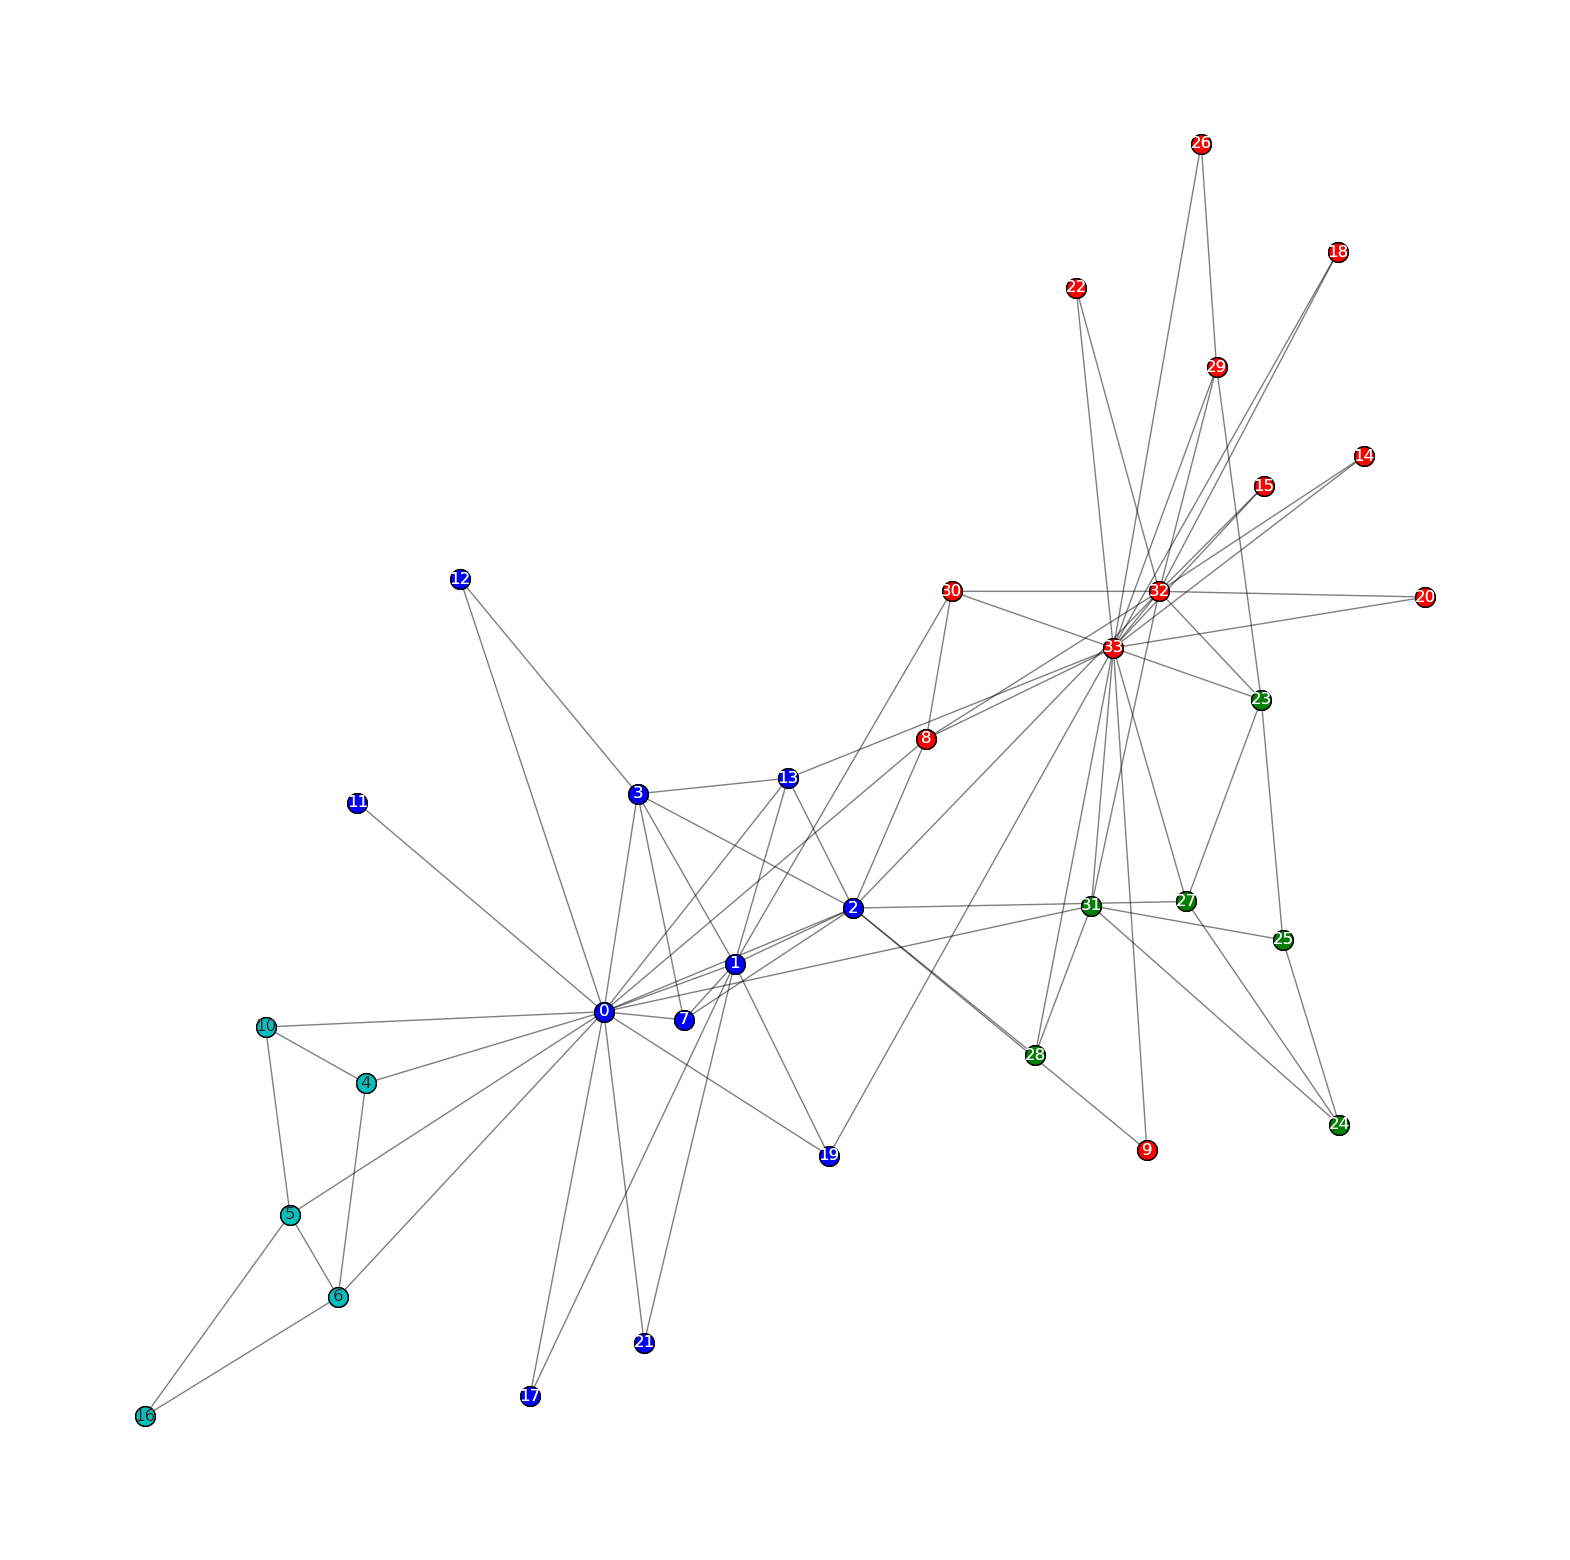

In [105]:
from cdlib import viz

pos = nx.spring_layout(g)
viz.plot_network_clusters(g, louvain_coms, pos, figsize=(20, 20), plot_labels=True)

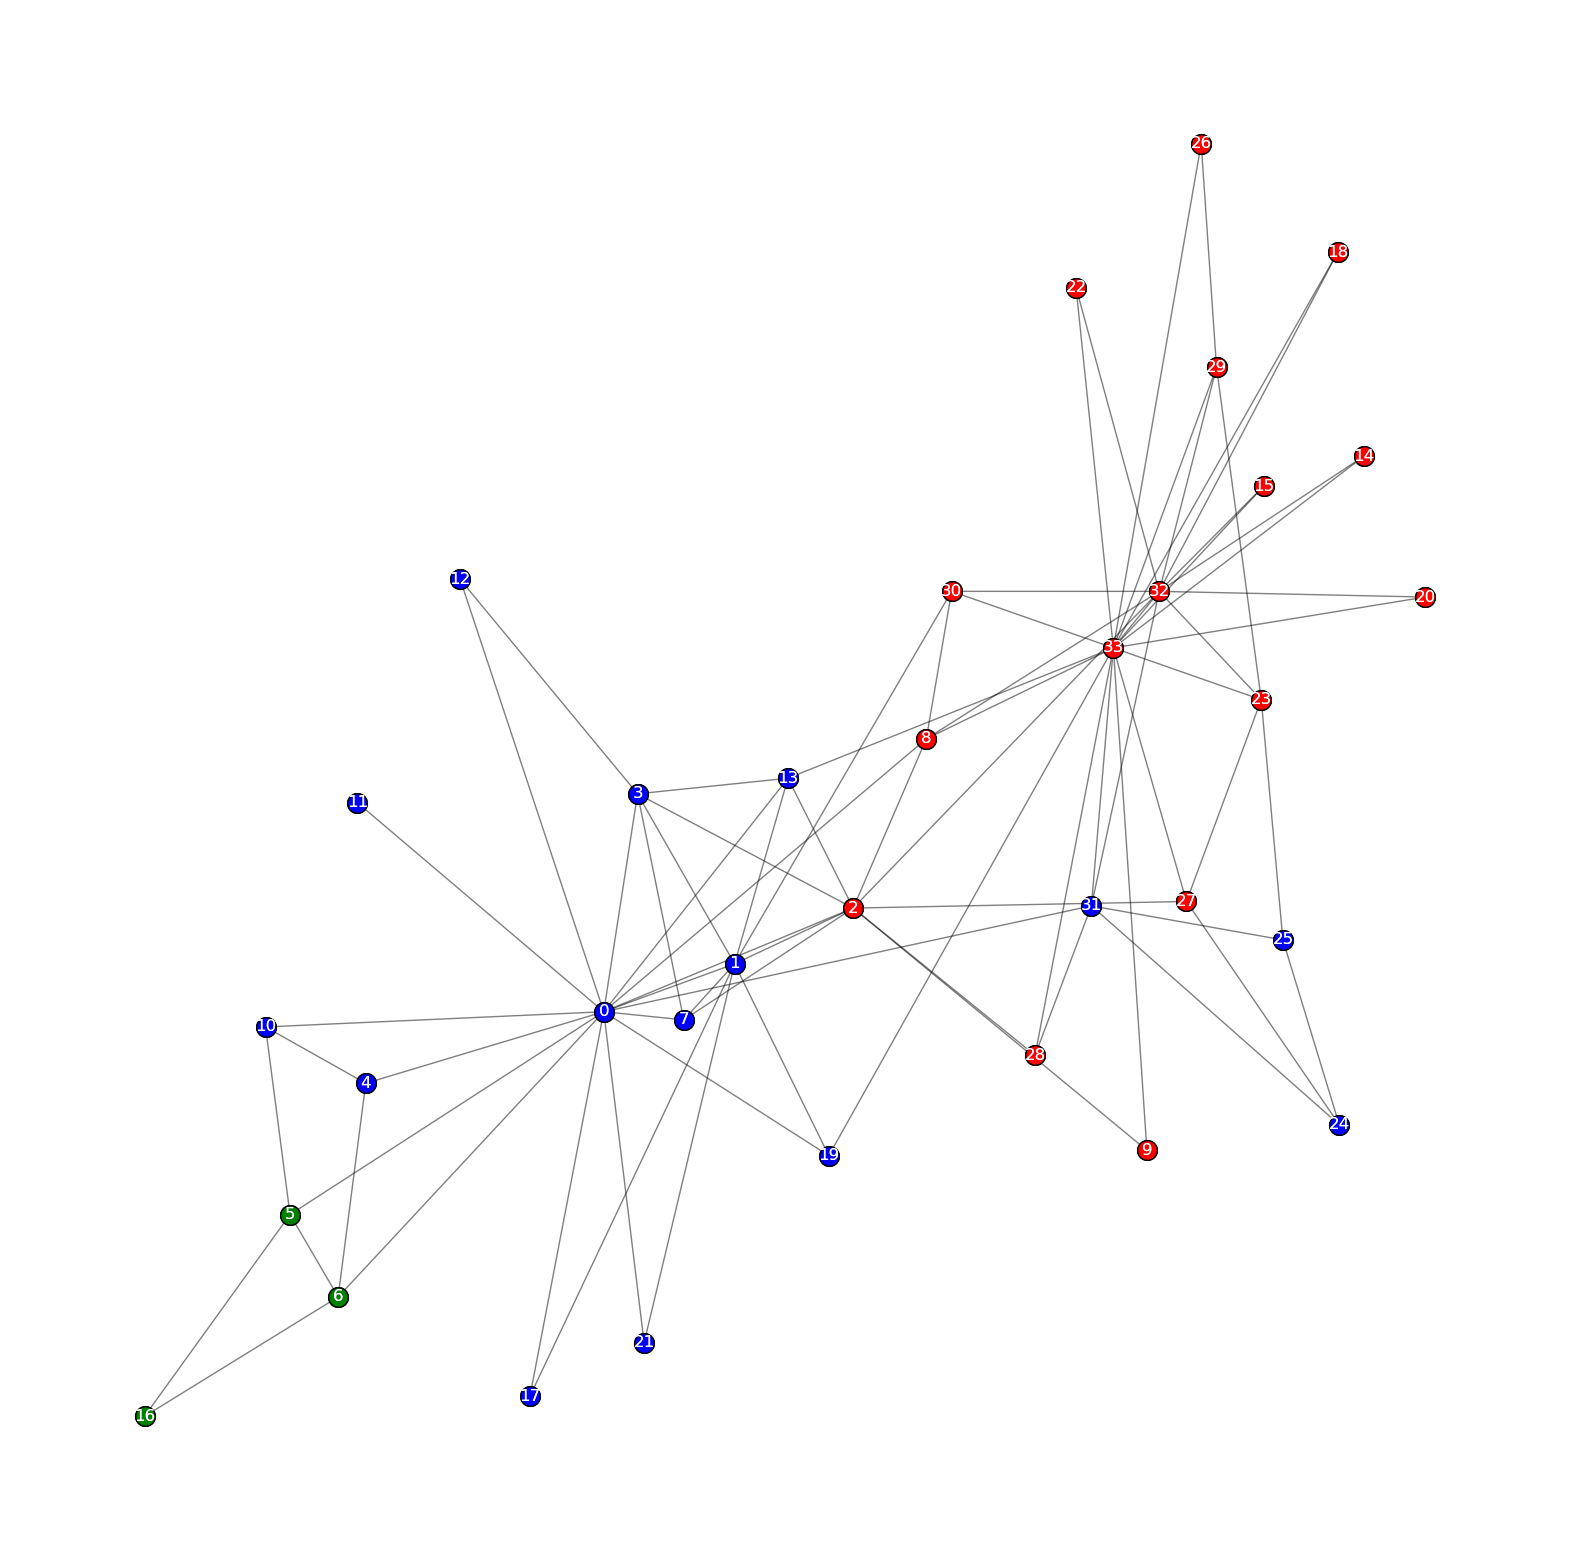

In [106]:
viz.plot_network_clusters(g, lp_coms, pos, figsize=(20, 20), plot_labels=True)

Such strategy is feasible when the network is small enogh. In case of medium size graphs an alternative is collapsing all community nodes into a single met-node and visualize the resulting community graph:

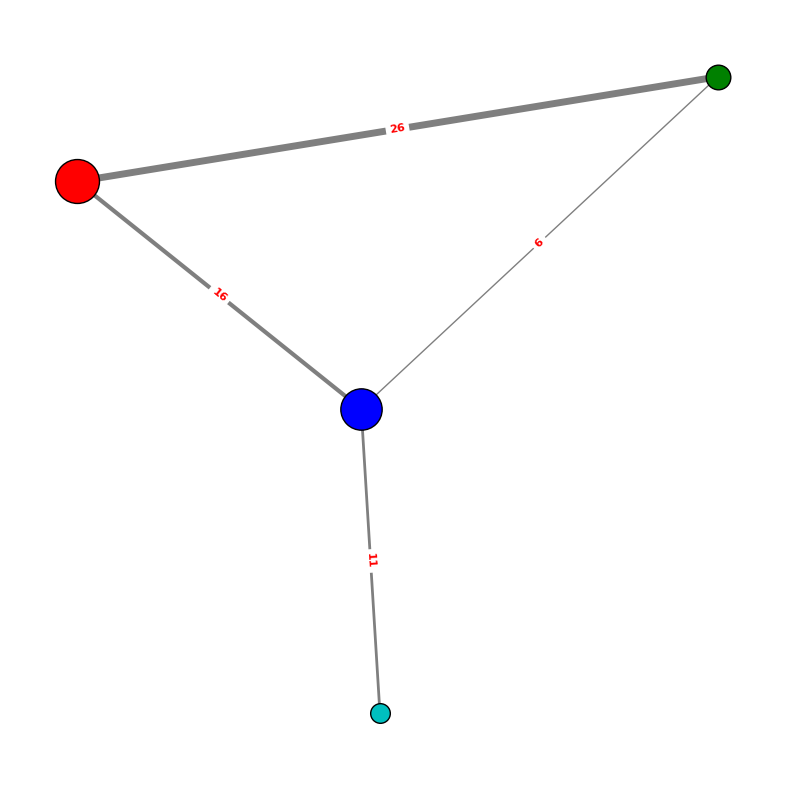

In [107]:
viz.plot_community_graph(g, louvain_coms, figsize=(10, 10))

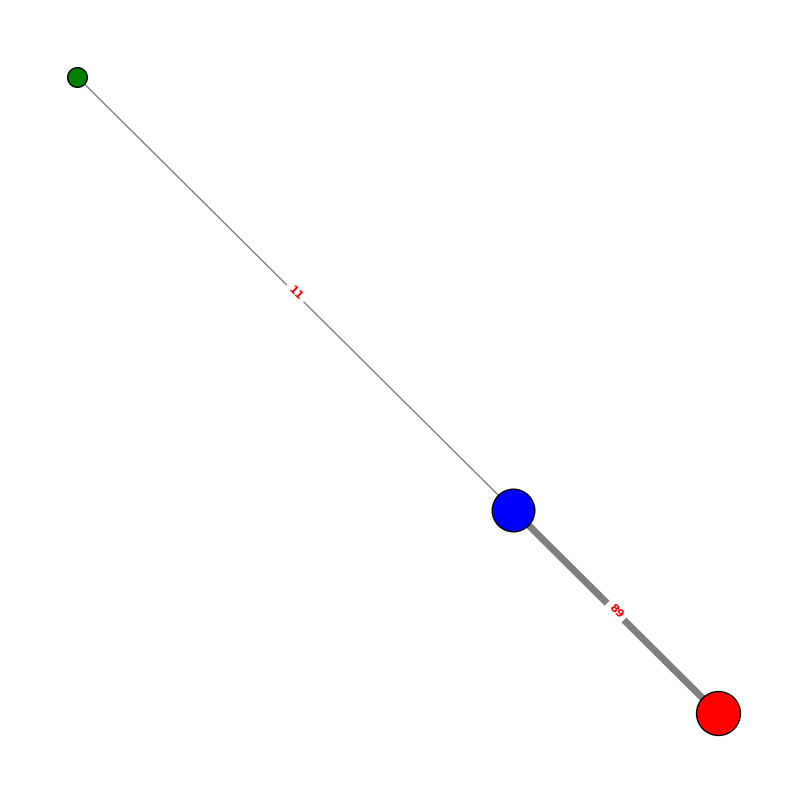

In [108]:
viz.plot_community_graph(g, lp_coms, figsize=(10, 10))

#### Community fitness/comparison visualization

Given one (or more) clustering it could be useful to visualize how a given fitness function distributes over the communities.

A nice way to do so is by using violin plots.

<Axes: xlabel='Algorithm', ylabel='internal_edge_density'>

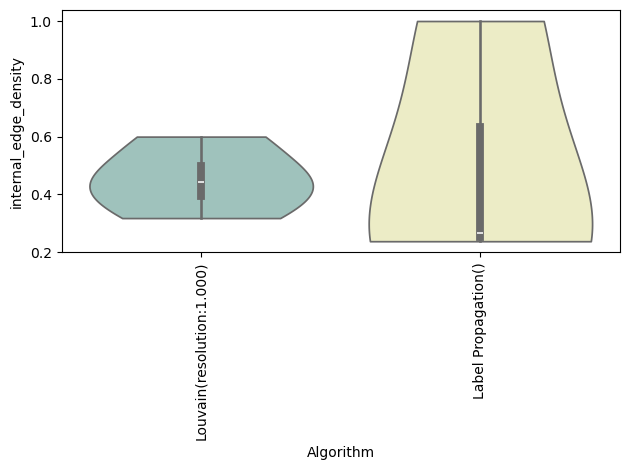

In [109]:
viz.plot_com_stat([louvain_coms, lp_coms], evaluation.internal_edge_density)

Another simple visualization type that allows getting a few insights on community characteristics is the scatter plot.

We can easily pair-wise compare fitness functions for one or more clustering as follows:

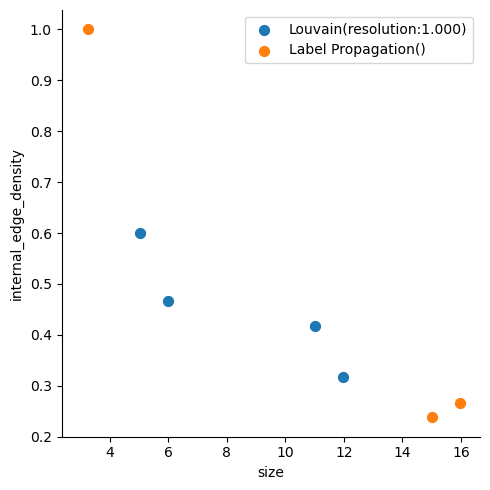

In [110]:
viz.plot_com_properties_relation([louvain_coms, lp_coms], evaluation.size, evaluation.internal_edge_density)

<a id="qualitative"></a>
### Qualitative evaluation ([to top](#top))

Another way to validate a clustering is to analyse the purity of each community w.r.t. an external attribute.

In our example, let's consider the 'club' attributes: what's the CD approach among the tested ones that allows to identify more "homogeneous" clusters?

In [111]:
def all_purities(coms, nth):
    purities = []
    for c in coms.communities:
        houses = []
        for node in c:
            if node in nth:
                houses.append(nth[node])
        
        cnt = Counter(houses)
        purity = max(cnt.values())/sum(cnt.values())
        purities.append(purity)
    return purities

In [112]:
attrs = nx.get_node_attributes(g, 'club')

In [113]:
louvain_purities = all_purities(louvain_coms, attrs)
louvain_purities

[0.9166666666666666, 1.0, 1.0, 1.0]

In [114]:
np.mean(louvain_purities), np.std(louvain_purities)

(0.9791666666666666, 0.03608439182435163)

In [115]:
lp_purities = all_purities(lp_coms, attrs)
lp_purities

[0.875, 0.8, 1.0]

In [116]:
np.mean(lp_purities), np.std(lp_purities)

(0.8916666666666666, 0.08249579113843053)

<a id="gt"></a>
### Ground Truth evaluation ([to top](#top))

Let assume we want to compare different clusterings over a set of network ground truth partitions.

In order to obtain a more interesting example, we can generate a few synthetic graphs with planted ground truth clusterings and perform CD upon them. <br/> We can easily visually compare their resuls as follows:

<Axes: xlabel='graph', ylabel='score'>

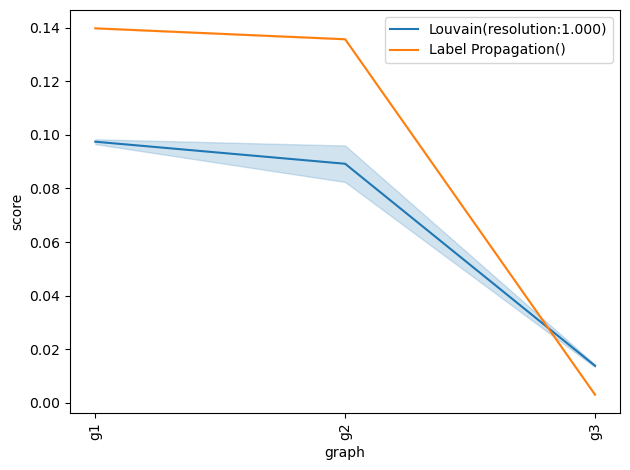

In [117]:
from cdlib import NodeClustering
from networkx.generators.community import LFR_benchmark_graph

g1 = LFR_benchmark_graph(1000, 3, 1.5, 0.5, min_community=20, average_degree=5)
g2 = LFR_benchmark_graph(1000, 3, 1.5, 0.6, min_community=20, average_degree=5)
g3 = LFR_benchmark_graph(1000, 3, 1.5, 0.7, min_community=20, average_degree=5)

names = ["g1", "g2", "g3"]
graphs = [g1, g2, g3]
references = []

# building the NodeClustering ground truth for the graphs
for g in graphs:
    ground_truth = NodeClustering(communities={frozenset(g.nodes[v]['community']) for v in g}, graph=g, method_name="reference")
    references.append(ground_truth)
    
algos = [algorithms.louvain, algorithms.label_propagation]

# Computing the visualization (2 execution per method, NMI as scoring for ground truth resemblance)
viz.plot_scoring(graphs, references, names, algos, scoring=evaluation.adjusted_mutual_information, nbRuns=2)

Finally, we can also compare different clustering obtained on the same graph by alternative algorithms among them. <br/>
Let's get back to our initial Karate Club graph and compute a few more clusterings upon it:

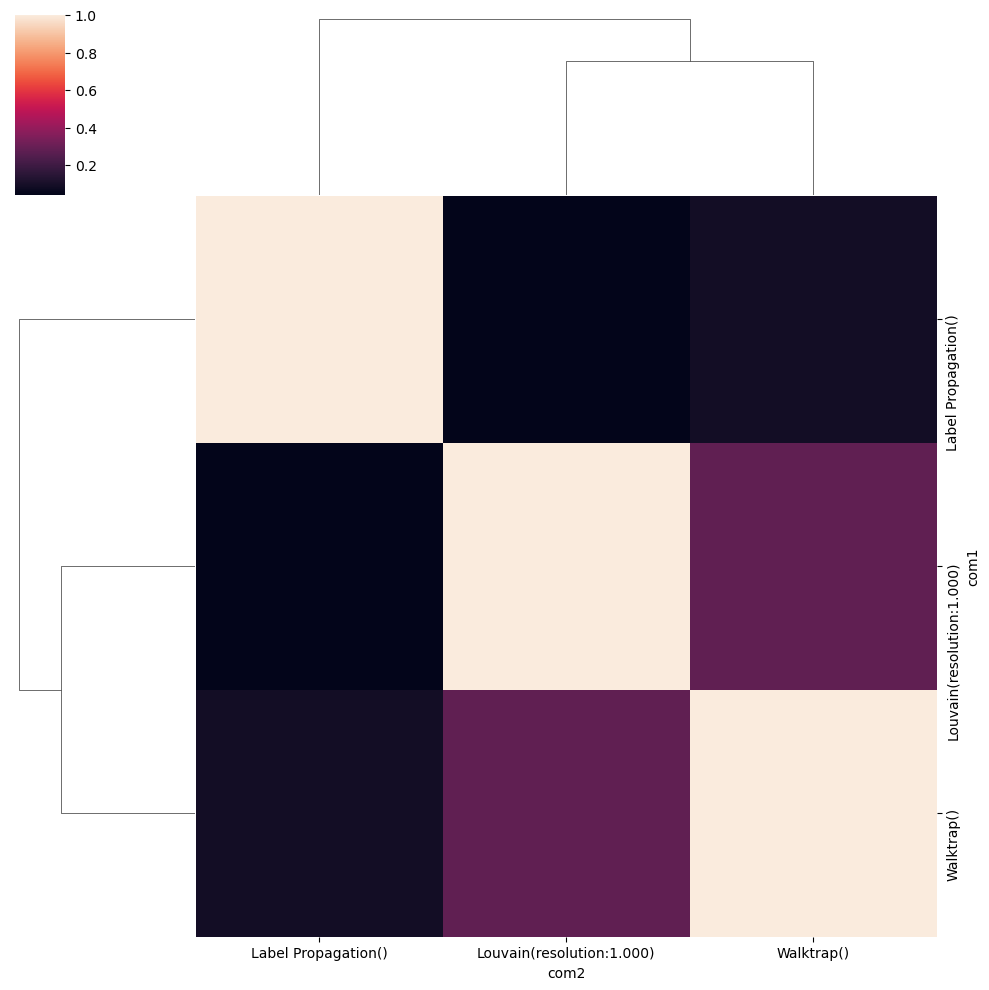

In [118]:

lp_coms = algorithms.label_propagation(g)
louvain_coms = algorithms.louvain(g)
wp_coms = algorithms.walktrap(g)

viz.plot_sim_matrix([louvain_coms, lp_coms, wp_coms],evaluation.adjusted_mutual_information)

<a id='top'></a>
# *Dynamic Community Discovery*

In this notebook are introduced the main steps for the extraction and topological analysis of communities from dynamic networks.

**Note:** this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started. For all the details, algorithm/methods/evaluation facilities available in ``CDlib``, please refer to the official [documentation](https://cdlib.readthedocs.io) and the dedicated notebook appendix.

In [119]:
from cdlib import algorithms, evaluation

In [120]:
from cdlib import TemporalClustering
g1 = LFR_benchmark_graph(1000, 3, 1.5, 0.5, min_community=20, average_degree=5)
g2 = LFR_benchmark_graph(1000, 3, 1.5, 0.6, min_community=20, average_degree=5)
g3 = LFR_benchmark_graph(1000, 3, 1.5, 0.7, min_community=20, average_degree=5)

names = ["g1", "g2", "g3"]
graphs = [g1, g2, g3]
tc = TemporalClustering()
for t in range(3):  # Simulating a dynamic graph by cycling through the three graphs
    g = graphs[t]  # In a real scenario, this would be a different graph
    coms = algorithms.louvain(g)  # here any CDlib algorithm can be applied
    tc.add_clustering(coms, t)

After built the temporal clustering it is possible to inspect the available temporal ids of the stored clusterings...

In [121]:
tc.get_observation_ids()

[0, 1, 2]

... and use them to access individual clusterings (thus allowing standard analyses as discussed in Chapter 8).

In [122]:
tc.get_clustering_at(1)

A simple measure of temporal stability is the clustering stability trend.

Given as input a TemporalClustering and a partition similarity score (e.g., NMI, NF1...) such a trend describe how much partitions tend to remain the same as time goes by.

In [123]:
trend = tc.clustering_stability_trend(evaluation.nf1)
trend

[0.02884553571428571, 0.03409126984126984]

Since our aim is to transform a static algorithm into a dinamic one, once computed the clusterings we have to match them across consecutive temporal ids.

We can check that our custom made approach does not came an explicit matching with...

In [124]:
tc.has_explicit_match()

False

After that we can use the <code>LifeCycle</code> object to compute events.

In [125]:
from cdlib import LifeCycle
lc = LifeCycle(tc)
lc.compute_events() 

We can get the supported event types:

In [126]:
lc.get_event_types()

['Birth',
 'Accumulation',
 'Growth',
 'Expansion',
 'Continuation',
 'Merge',
 'Offspring',
 'Reorganization',
 'Death',
 'Dispersion',
 'Shrink',
 'Reduction',
 'Continuation',
 'Split',
 'Ancestor',
 'Disassemble']

In [127]:
ev = lc.get_event("1_2") # to compute events for all communities use the get_events() method

In [128]:
print(ev.out_flow)  # to get the out flow of the community 1_2
print(ev.in_flow)  # to get the in flow of the community 1_2
print(ev.from_event)  # to get the from events of the community 1_2
print(ev.to_event)  # to get the to events of the community 1_2

{'2_0': {99, 677, 778, 475, 284, 670}, '2_1': {996, 682, 403, 669, 94}, '2_2': {128, 163, 868, 234, 216, 154}, '2_3': {384, 260, 264, 937, 878, 50, 734}, '2_4': {745, 186, 637, 54}, '2_5': {288, 802, 484, 903}, '2_6': {6, 107, 144, 822, 311, 474}, '2_7': {641, 42, 331, 460, 698, 93, 351}, '2_8': {353, 969, 212, 759, 506, 573}, '2_9': {771, 195, 901, 808, 308, 181}, '2_10': {320, 104, 106, 695, 793, 797}, '2_11': {176, 584, 676}, '2_12': {516, 38, 10, 149, 56}, '2_13': {861, 742}, '2_14': {315, 557}, '2_15': {414}, '2_16': {448, 904, 747, 910, 59}, '2_17': {387}}
{'0_0': {264, 163, 996}, '0_1': {676, 260, 901, 104, 176, 403, 181, 54, 475, 315}, '0_2': {99, 516, 808, 144, 311, 793}, '0_3': {288, 742, 903, 584, 759, 506}, '0_4': {384, 802, 771, 387, 38, 778, 747, 557, 154, 734}, '0_5': {50, 234, 484, 637}, '0_6': {331, 861, 149}, '0_7': {969, 42, 573}, '0_8': {128, 195, 669, 107, 93, 797}, '0_9': {682, 106, 308, 56, 59}, '0_10': {320, 6, 216, 284, 414}, '0_11': {474, 677, 670}, '0_12': {9

In [129]:
out_flow = lc.analyze_flow("1_2", "+") # if the community id is not specified all the communities are considered
in_flow = lc.analyze_flow("1_2", "-")

In addition, if the temporal network comes with attributes associated to the nodes (either dynamically changing or not - i.e., political leanings), the library provides a set of tools to analyze the typicality of the events.

Setting and retreiving node attributes is straightforward:

In [130]:
import random
def random_leaning():
    """Generates a random political leaning attribute for 250 nodes over 10 time steps."""
    attrs = {}
    for i in range(250): # 250 nodes
        attrs[i] = {}
        for t in range(10): # 10 time steps
            attrs[i][t] = random.choice(["left", "right"])
    return attrs

tc = TemporalClustering()
for t in range(0, 10):
    g = LFR_benchmark_graph(
            n=250,
            tau1=3,
            tau2=1.5,
            mu=0.1,
            average_degree=5,
            min_community=20,
            seed=10,
    )
    coms = algorithms.louvain(g)  # here any CDlib algorithm can be applied
    tc.add_clustering(coms, t)

events = LifeCycle(tc)
events.compute_events("facets") # or "greene" or "asur"
events.set_attribute(random_leaning(), "political_leaning")
attrs = events.get_attribute("political_leaning")

events.analyze_flow("1_1", "+",  attr="political_leaning") # to analyze the flow

{'Unicity': 0.3125,
 'Identity': 0.5174495341614906,
 'Outflow': 0.0,
 'size': 32,
 'political_leaning_H': 0.9886994082884974,
 'political_leaning_H_change': 0.0016027859598900518,
 'political_leaning_purity': 0.5625,
 'political_leaning_mca': 'right'}

The library provides a set of tools to visualize the events and flows detected in the community structure of a network.

In [131]:
from cdlib.viz import *

Here an example of how to visualize community events, flows and polytree:

In [132]:

fig = plot_flow(events)
fig.show()

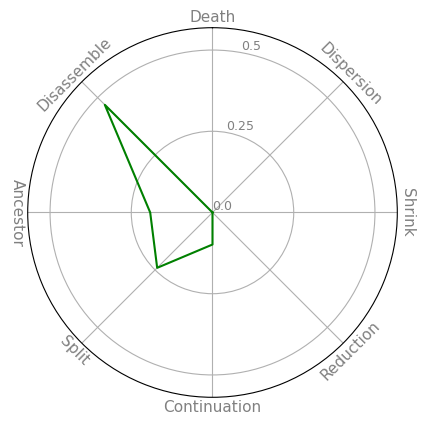

In [134]:
fig = plot_event_radar(events, "1_2", direction="+") # only out events

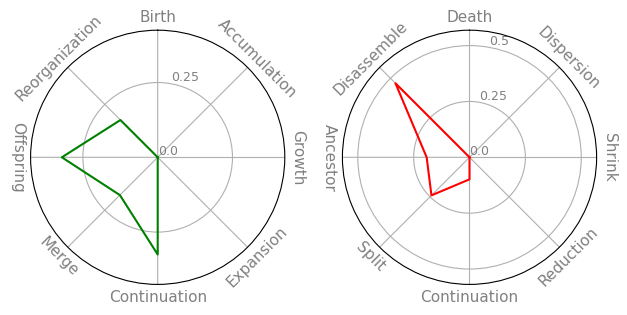

In [135]:
fig = plot_event_radars(events, "1_2") # both in and out events

In [136]:

fig = typicality_distribution(events, "+")
fig.show()

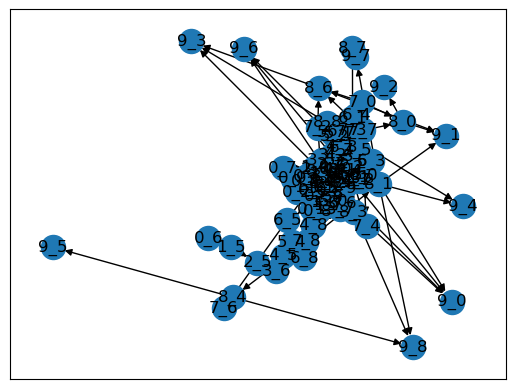

In [137]:
dg = events.polytree()
fig = nx.draw_networkx(dg, with_labels=True)

# Exercise: Identifying echo chambers on reddit
An echo chamber is commonly defined as a polarized situation in which beliefs are amplified or reinforced by communication repetition inside a closed system and insulated from rebuttal.

In this exercise, we will adopt a methodology that leverages community detection and node attributes to identify echo chambers on reddit political discussions.

First, let's download the data. This downloads three files to your machine. Each of them is a snapshot of 6months of discussions about gun control on Reddit. Nodes are users connected if they discuss together. Each node is labeled as either 'protrump' or 'antitrump'. You can find this information by getting the 'discrete_leaning' via networkx's <code>nx.get_node_attribute()</code>.


Files are named "guncontrol-tX.gexf", where X is a number in [0,1,2] that identifies a semester. All files are gexf-formatted. you can read them with <code>nx.read_gexf()</code>

In [ ]:
%%bash
for t in 0 1 2; do
  curl -L "https://raw.githubusercontent.com/andreafailla/MBD-SNA-Lab/main/data/politics-t${t}.gexf" \
       -o "guncontrol-t${t}.gexf"
done

Load the data in the cell below, in a variable called 'g'. Then, obtain the 'discrete_leaning' attribute for each node and store them in a variable called 'attrs'.

In [145]:
g = nx.read_gexf("guncontrol-t0.gexf")
attrs = nx.get_node_attributes(g, 'discrete_leaning')

We will use the EVA algorith, a modification of the Louvain that balances structure and community attribute purity. You can call it with <code>algorithms.eva(g, labels={'discrete_leaning': attrs})

In [146]:
# perform cd here
from cdlib import algorithms
eva_coms = algorithms.eva(g, labels={'discrete_leaning': attrs})

Below are two functions that compute the conductance and purity. They take as inputs only the graph and the list of nodes representing the community.

In [147]:
def community_conductance(graph, community):
    """
    Compute the conductance of a given community in a graph.

    Parameters:
    - graph: networkx.Graph
    - community: list or set of node IDs

    Returns:
    - conductance: float
    """
    community_set = set(community)
    cut_edges = 0
    volume = 0

    for node in community_set:
        for neighbor in graph.neighbors(node):
            if neighbor not in community_set:
                cut_edges += 1
        volume += graph.degree(node)

    if volume == 0 or volume == graph.size() * 2:
        return 0.0

    outside_volume = sum(dict(graph.degree()).values()) - volume
    denom = min(volume, outside_volume)
    if denom == 0:
        return 0.0

    return cut_edges / denom

def community_purity(g, community, attr_name):
    """
    Compute the purity of a community based on a given attribute.

    Parameters:
    - g: networkx.Graph
    - community: list or set of node IDs
    - attr_name: name of the attribute to evaluate purity

    Returns:
    - purity: float
    """
    community_set = set(community)
    attr_values = [g.nodes[node][attr_name] for node in community_set if attr_name in g.nodes[node]]
    
    if not attr_values:
        return 0.0
    
    most_common_value, count = Counter(attr_values).most_common(1)[0]
    return count / len(attr_values)


For each community, compute their purity and conductance. Then, print 'Echo chamber detected' if conductance < 0.5 and purity > 0.7. Otherwise print 'This is not an echo chamber!'.

In [ ]:
count_echo_chambers = 0
for community in eva_coms.communities:
    conductance = community_conductance(g, community)
    purity = community_purity(g, community, 'discrete_leaning')
    
    if conductance < 0.5 and purity > 0.7:
        print("Echo chamber detected!")
        print(f"Conductance: {conductance}, Purity: {purity}")
        print()
        count_echo_chambers += 1
    else:
        print("This is not an echo chamber")
        print(f"Conductance: {conductance}, Purity: {purity}")
        print()

This is not an echo chamber
Conductance: 0.1919191919191919, Purity: 0.6048387096774194

This is not an echo chamber
Conductance: 0.32245357343837927, Purity: 0.4566929133858268

This is not an echo chamber
Conductance: 0.461734693877551, Purity: 0.6666666666666666

This is not an echo chamber
Conductance: 0.4266666666666667, Purity: 0.6344086021505376

Echo chamber detected!
Conductance: 0.3238434163701068, Purity: 0.7333333333333333

This is not an echo chamber
Conductance: 0.7438423645320197, Purity: 0.8181818181818182

This is not an echo chamber
Conductance: 0.25, Purity: 0.6875

This is not an echo chamber
Conductance: 0.0, Purity: 0.5

This is not an echo chamber
Conductance: 0.0, Purity: 0.5

This is not an echo chamber
Conductance: 0.0, Purity: 0.5

This is not an echo chamber
Conductance: 0.3333333333333333, Purity: 0.5

Echo chamber detected!
Conductance: 0.0, Purity: 1.0

This is not an echo chamber
Conductance: 0.0, Purity: 0.5

Echo chamber detected!
Conductance: 0.0, Pur